<div class="alert alert-info">
    <h1>Proyecto DevF</h1>
    <p>Entender los periodos con más alto flujo en las gosolineras para poder enviar más personal y cubrir la demanda del consumo de combustible</p>
</div>

<div class="alert alert-info">
    <h3>Librerias</h3>
</div>

In [ ]:
install.packages("corrplot")
install.packages("lubridate")
install.packages("zoo")

In [1]:
rm(list=ls())

In [2]:
library(plyr)
library(tidyverse)
library(ggplot2)
library(corrplot)
library(plotly)
library(lubridate, warn.conflicts = FALSE)
library(zoo)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()

corrplot 0.84 loaded


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following objects are masked from ‘package:plyr’:

    arrange, mutate, rename, summarise


The 

<div class="alert alert-info">
    <h3>Cargando la base de datos</h3>
</div>

In [3]:
# Directorio de la carpeta contenedor
dir <- "/Users/israelvargas/Documents/Diplomados-Cursos/DevF/Data\ Science/Poyecto/devF_proyecto/Assets"
# Lectura del archivo
dataset <- read.csv(
    paste(
        dir, 
        "Abr2019-Jun2019wet.csv", 
        sep = "/"
      ), 
    stringsAsFactors = TRUE,
    na.strings = "no_value",
    strip.white = TRUE
  )
# Visualización de la base de datos
head(dataset)

,Date2,Textbox70,DocNo,Type1,Product1,Textbox41,Textbox42,Price1,Textbox44,POS1,Pump1,Cashier1,Name1,MOP11,MOP21,MOP31,Textbox34,Textbox35
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<lgl>,<lgl>,<fct>,<fct>
1,01/04/2019,06:57,326007,Boleta,GAS93RM,Gasolina 93 octanos,"52,98","755,00","40.000,00",CLBO0416,6,1006,MANUEL MARIN,CASH,NA,NA,"1.549.807,42","1.187.717.898,00"
2,01/04/2019,06:59,326008,Boleta,GAS95RM,Gasolina 95 octanos,"31,53","793,00","25.000,00",CLBO0416,4,1012,JORGE PINO,CASH,NA,NA,"1.549.807,42","1.187.717.898,00"
3,01/04/2019,06:59,10414,Factura,DIXTRA,SD Extra Petroleo Di,"72,95","581,00","42.382,00",CLBO0416,5,1019,ALFREDO LEON,CASH,NA,NA,"1.549.807,42","1.187.717.898,00"
4,01/04/2019,07:01,326009,Boleta,GAS93RM,Gasolina 93 octanos,"3,98","755,00","3.000,00",CLBO0416,4,1006,MANUEL MARIN,CASH,NA,NA,"1.549.807,42","1.187.717.898,00"
5,01/04/2019,07:05,326010,Boleta,GAS97RM,V-POWER Gasolina 97,"5,88","850,00","5.000,00",CLBO0416,1,1019,ALFREDO LEON,CASH,NA,NA,"1.549.807,42","1.187.717.898,00"
6,01/04/2019,07:06,326012,Boleta,GAS93RM,Gasolina 93 octanos,"10,60","755,00","8.000,00",CLBO0416,3,1012,JORGE PINO,CASH,NA,NA,"1.549.807,42","1.187.717.898,00"


<div class="alert alert-warning">
    <h3>Entendiendo la base de datos</h3>
    <p>Proceso preliminar para realizar una limpieza con base en la información dada de la base de datos, así como la omisión de variables poco relevantes para este análisis.</p>
</div>

In [4]:
aux_group <- group_by(dataset,POS1,MOP21) %>%
summarise(count=n())
aux_group

`summarise()` regrouping output by 'POS1' (override with `.groups` argument)



POS1,MOP21,count
<fct>,<lgl>,<int>
CLBO0416,NA,56992


In [5]:
aux_group <- group_by(dataset,POS1,MOP31) %>%
summarise(count=n())
aux_group

`summarise()` regrouping output by 'POS1' (override with `.groups` argument)



POS1,MOP31,count
<fct>,<lgl>,<int>
CLBO0416,NA,56992


<div class = "alert alert-warning">    
    <h3>Acciones a tomar:</h3>
    <ul>
        <li> Las columnas MOP21, MOP31 NO continen informacion, se eliminan de la base de datos.
        <li> Las columnas Textbox34 y Textbox35, don información de IP, se omiten para este análisis.
    </ul>
</div>

<div class="alert alert-info">
    <h3>Eliminando y Renombrando las columnas</h3>
</div>

In [6]:
# Eliminando las columnas inútiles
dataset <- select(dataset,-(MOP21:Textbox35))
# Renombrando las columnas de la base de datos
colnames(dataset) <- c(
    'Fecha',
    'Hora',
    'Ticket',
    'TpoTicket',
    'Producto',
    'DescProducto',
    'Litros',
    'Precio_Litro',
    'Total_Consumo',
    'Gasolinera',
    'Bomba',
    'ID_empleado',
    'Nombre_empleado',
    'Tpo_pago'
)
head(dataset)

,Fecha,Hora,Ticket,TpoTicket,Producto,DescProducto,Litros,Precio_Litro,Total_Consumo,Gasolinera,Bomba,ID_empleado,Nombre_empleado,Tpo_pago
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
1,01/04/2019,06:57,326007,Boleta,GAS93RM,Gasolina 93 octanos,"52,98","755,00","40.000,00",CLBO0416,6,1006,MANUEL MARIN,CASH
2,01/04/2019,06:59,326008,Boleta,GAS95RM,Gasolina 95 octanos,"31,53","793,00","25.000,00",CLBO0416,4,1012,JORGE PINO,CASH
3,01/04/2019,06:59,10414,Factura,DIXTRA,SD Extra Petroleo Di,"72,95","581,00","42.382,00",CLBO0416,5,1019,ALFREDO LEON,CASH
4,01/04/2019,07:01,326009,Boleta,GAS93RM,Gasolina 93 octanos,"3,98","755,00","3.000,00",CLBO0416,4,1006,MANUEL MARIN,CASH
5,01/04/2019,07:05,326010,Boleta,GAS97RM,V-POWER Gasolina 97,"5,88","850,00","5.000,00",CLBO0416,1,1019,ALFREDO LEON,CASH
6,01/04/2019,07:06,326012,Boleta,GAS93RM,Gasolina 93 octanos,"10,60","755,00","8.000,00",CLBO0416,3,1012,JORGE PINO,CASH


<div class="alert alert-info">
    <h2>Análisis exploratorio</h2>
    <p>Uso de métodos simples de R, para entener la infomración</p>
</div>

In [7]:
###
# Filas y columnas
###
print(paste('Número de filas en el dataframe', nrow(dataset), sep=": "))
print(paste('Número de columnas en el dataframe', ncol(dataset), sep=": "))

[1] "Número de filas en el dataframe: 56992"
[1] "Número de columnas en el dataframe: 14"


In [8]:
###
# Descripción del dataset
###
str(dataset)

'data.frame':	56992 obs. of  14 variables:
 $ Fecha          : Factor w/ 92 levels "01/04/2019","01/05/2019",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Hora           : Factor w/ 1431 levels "00:00","00:01",..: 409 411 411 413 417 418 419 420 422 423 ...
 $ Ticket         : Factor w/ 56838 levels "*METROL","00040",..: 4109 4110 4 4111 4112 4113 4114 4115 4116 4117 ...
 $ TpoTicket      : Factor w/ 3 levels "Boleta","Factura",..: 1 1 2 1 1 1 1 1 1 1 ...
 $ Producto       : Factor w/ 4 levels "DIXTRA","GAS93RM",..: 2 3 1 2 4 2 1 2 3 3 ...
 $ DescProducto   : Factor w/ 4 levels "Gasolina 93 octanos",..: 1 2 3 1 4 1 3 1 2 2 ...
 $ Litros         : Factor w/ 6952 levels "- 20,05","- 20,13",..: 4287 2032 6058 1884 3990 141 685 1752 1383 2942 ...
 $ Precio_Litro   : Factor w/ 126 levels "0,00","501,00",..: 44 73 9 44 106 44 9 44 73 73 ...
 $ Total_Consumo  : Factor w/ 12415 levels "0,00","1.000,00",..: 7961 2589 8711 4196 10252 12072 59 1873 1443 5005 ...
 $ Gasolinera     : Factor w/ 1 level "CLBO0416":

In [9]:
###
# Convirtiendo variables de caracter a numéricas
###
dataset$Litros <- str_replace(dataset$Litros,"\\,",".") %>% as.numeric()
dataset$Precio_Litro <- str_replace(dataset$Precio_Litro,',00','') %>%
as.numeric()
dataset$Total_Consumo <- str_replace(dataset$Total_Consumo,',00','') %>%
str_replace('\\.','') %>%
as.numeric()
###
# El Warning sucede debido a que  la bariable Litros, tiene valores negativos. Son aclaraciones
###

Warning message in function_list[[k]](value):
“NAs introducidos por coerción”


In [10]:
###
# Estadísticas del dataframe
###
stads <- summary(dataset)
stads

        Fecha            Hora           Ticket        TpoTicket    
 17/05/2019:  840   12:18  :   88   *METROL:   78   Boleta :52573  
 31/05/2019:  810   10:23  :   86   123    :   36   Factura: 4092  
 24/05/2019:  802   11:37  :   86   1      :   16   GDD    :  327  
 26/04/2019:  801   13:14  :   84   2      :    9                  
 12/04/2019:  794   11:20  :   81   12     :    7                  
 18/04/2019:  785   11:36  :   81   5      :    5                  
 (Other)   :52160   (Other):56486   (Other):56841                  
    Producto                   DescProducto       Litros        Precio_Litro  
 DIXTRA : 7210   Gasolina 93 octanos :32130   Min.   :  0.00   Min.   :  0.0  
 GAS93RM:32130   Gasolina 95 octanos :15978   1st Qu.: 12.52   1st Qu.:773.0  
 GAS95RM:15978   SD Extra Petroleo Di: 7210   Median : 24.45   Median :790.0  
 GAS97RM: 1674   V-POWER Gasolina 97 : 1674   Mean   : 27.21   Mean   :771.3  
                                              3rd Qu.: 39.74 

              Litros Precio_Litro Total_Consumo
Litros             1           NA            NA
Precio_Litro      NA    1.0000000     0.0516128
Total_Consumo     NA    0.0516128     1.0000000


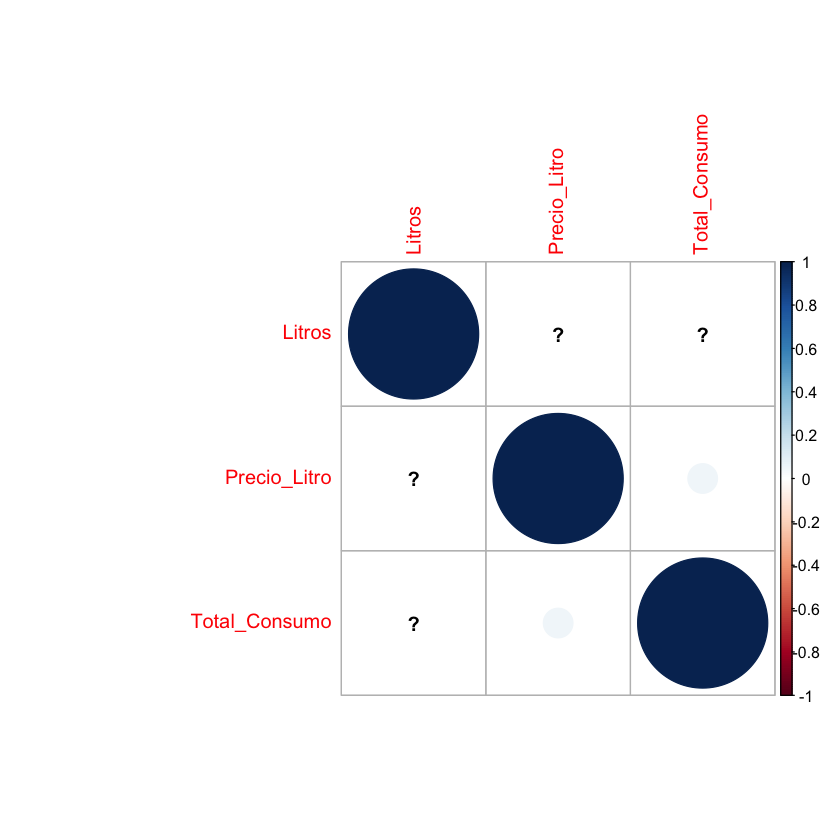

In [11]:
correlacion <- select(dataset,Litros,Precio_Litro,Total_Consumo) %>%
cor(method = c("pearson"))
print(correlacion)
corrplot(correlacion)

<div class="alert alert-warning">
    <h3>Observaciones relevantes:</h3>
    <ul>
        <li> <b>Gasolinera:</b> La variable Gasolinera, es una variable única dentro de la base de datos.
        <li> <b>Ticket: </b> Es una variable que se comporta como una variable de tipo ID (el número de valores diferentes es casí igual o igual al número de filas dentro del dataset), solo se puede utilizar como una variable de conteo de enventos para el análisis.  
        <li> <b>Producto y DescProducto: </b> Son variables iguales, se el problema con DescProducto, es que tiene valores ausentes dentro de la base, por eso no empatan los valores del Producto-DescProducto (referente al conteo), procedemos a hacer uso solo de la variable Producto para este análisis.
        <li> <b>Litros, Precio_litro, Total_Consumo: </b> Son variables continuas. Total_Consumo es el resultado de multiplicar litros y precio_litro.
        <li> <b>Bomba: </b> La variable bomba es una varaible de tipo cátegorica de tipo ordinal, nos sirve para endender la demanda por bomba.
        <li> <b>ID_empleado y Nombre_empleado: </b> Son variables categoricas nominales, son relacionadas entre si, pero presentan el mismo problema que Producto y DescProducto, pues continen valores missing, que impiden su relación total, por ello solo tomaremos la variable ID_empleado.
        <li> <b>Tpo_pago: </b> Es una varaible de tipo categorica nominal, se omitira su uso para los requerimientos de este análisis.
    </ul>
</div>

<div class="alert alert-info">
    <h2>Análisis descriptivo</h2>
</div>

`summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 8 x 2
  Bomba count
  <int> <int>
1     4 10019
2     3  9783
3     6  9709
4     5  7408
5     1  6176
6     2  5922
7     8  4741
8     7  3234


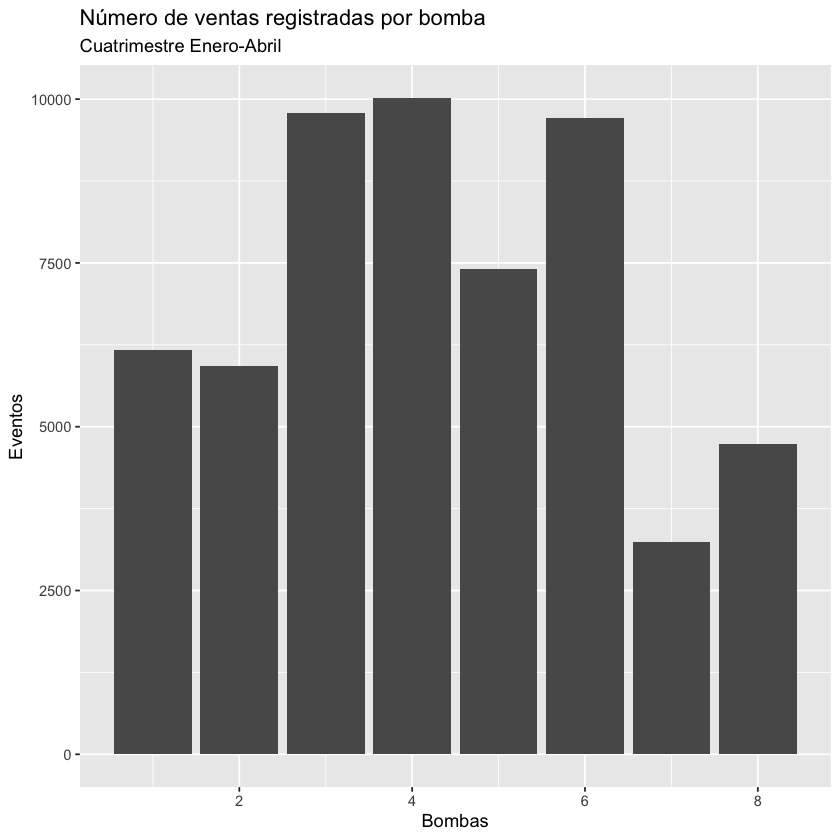

In [12]:
###
# Visualización de la demanda de tickets por bomba total
###
aux_group <- group_by(dataset,Bomba) %>%
summarise(count=n()) %>%
arrange(desc(count))
print(aux_group)
bar <- ggplot(aux_group,aes(x=Bomba,y=count)) + 
geom_bar(stat = "identity") +
labs(title="Número de ventas registradas por bomba",subtitle='Cuatrimestre Enero-Abril',x="Bombas",y="Eventos")
bar

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“tz(): Don't know how to compute timezone for object of class factor; returning "UTC". This warning will become an error in the next major version of lubridate.”


Fecha,count,dia_numero,dia_nombre,mes,year,sem,monthweek
<fct>,<int>,<int>,<ord>,<ord>,<fct>,<dbl>,<dbl>
01/04/2019,686,5,Sab,Apr,Apr 2019,13,1
02/04/2019,717,6,Dom,Apr,Apr 2019,13,1
03/04/2019,692,0,Lun,Apr,Apr 2019,13,1
04/04/2019,641,2,Mie,Apr,Apr 2019,13,1
05/04/2019,747,3,Jue,Apr,Apr 2019,13,1
06/04/2019,552,4,Vie,Apr,Apr 2019,13,1
07/04/2019,440,5,Sab,Apr,Apr 2019,13,1
08/04/2019,667,0,Lun,Apr,Apr 2019,14,2
09/04/2019,663,1,Mar,Apr,Apr 2019,14,2


Warning message:
“Use of `aux_group$count` is discouraged. Use `count` instead.”


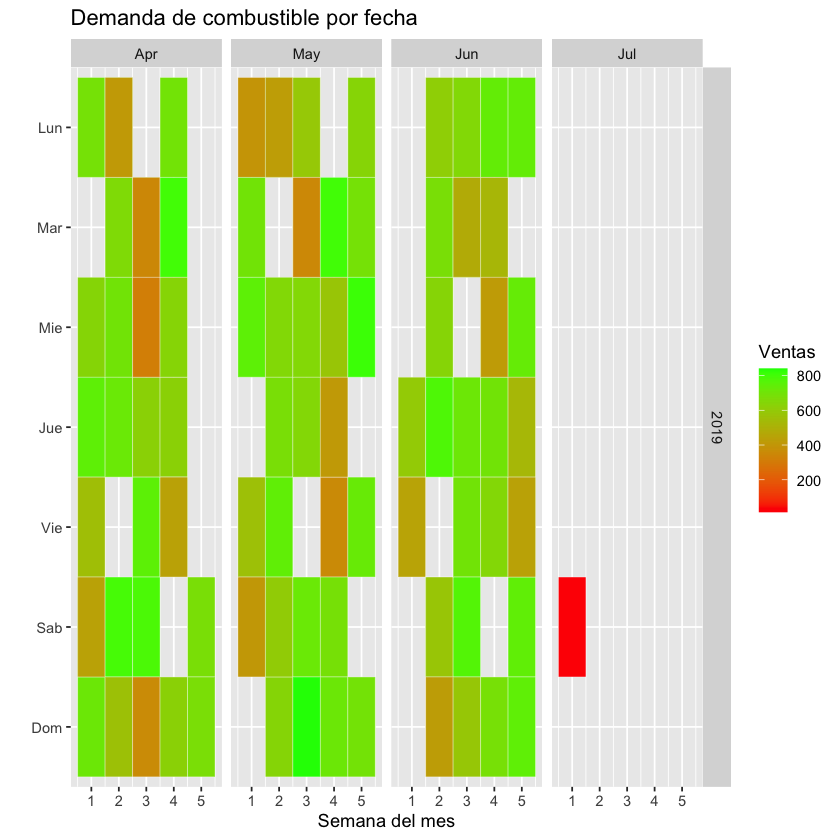

In [15]:
###
# Visualizando por fecha la cantidad de eventos realizados
###
aux_group <- group_by(dataset,Fecha) %>%
summarise(count=n()) 
#Obtenemos el dia de la semana en número (1:7)
aux_group$dia_numero <- as.POSIXlt(aux_group$Fecha)$wday 
#Obtenemos el dia de la semana en nombre (Lun:Dom)
aux_group$dia_nombre <- factor(
    aux_group$dia_numero,
    levels=rev(0:6),
    labels=rev(
        c("Lun","Mar","Mie","Jue","Vie","Sab","Dom")
    ),
    ordered=TRUE
)
# Obetnemos el mes del año
aux_group$mes <- factor(
    month(aux_group$Fecha),
    levels=as.character(1:12),
    labels=c("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"),
    ordered=TRUE
) 
# Obtenemos el año Mes Año
aux_group$year <- factor(as.yearmon(as.Date(aux_group$Fecha,"%d/%m/%Y")))
# Inicializamos las semanas del año
aux_group$sem <- as.numeric(format(as.Date(aux_group$Fecha,"%d/%m/%Y"),"%W"))
# Normalizamos las semanas para que arranquen en el primero de cada mes
aux_group <- ddply(aux_group,.(year),transform,monthweek=1+sem-min(sem))
aux_group
p <- ggplot(aux_group, aes(monthweek, dia_nombre, fill = aux_group$count)) + 
geom_tile(colour = "white") + 
facet_grid(year(as.Date(aux_group$Fecha,"%d/%m/%Y"))~mes) + 
scale_fill_gradient(low="red", high="green") + 
xlab("Semana del mes") + ylab("") + 
ggtitle("Demanda de combustible por fecha") + 
labs(fill = "Ventas") 
p